<a href="https://colab.research.google.com/github/jabhij/MusicTherapyTreatment_EmotionDetection/blob/main/Mood_Detection_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from keras import models
from keras.utils import to_categorical, np_utils

from tensorflow import convert_to_tensor
from tensorflow.image import grayscale_to_rgb
from tensorflow.data import Dataset
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D, MaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [18]:
path = '/content/drive/MyDrive/Mood-Detection-Project/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'
path

'/content/drive/MyDrive/Mood-Detection-Project/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'

In [20]:
data = pd.read_csv(path)

In [21]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [23]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [25]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [24]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [26]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [27]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [28]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [29]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

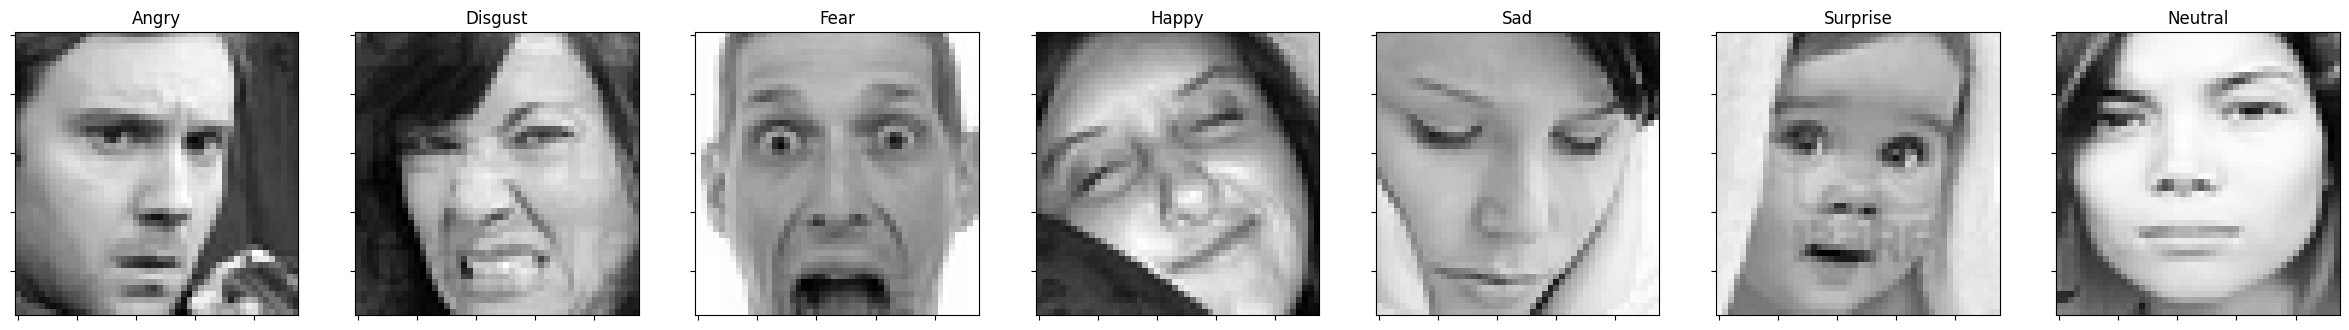

In [30]:
plot_all_emotions()

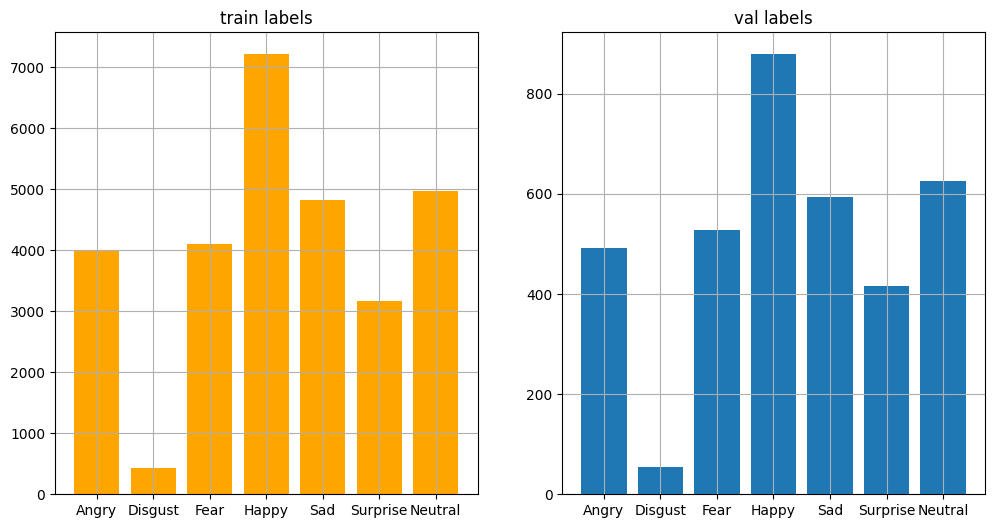

In [31]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [32]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [33]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [87]:
model = models.Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='sigmoid'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [88]:
from keras.optimizers.optimizer import learning_rate_schedule
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 8, 8, 64)          73792     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 4, 4, 64)       

In [99]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=25)

Epoch 1/50
1149/1149 [==============================] - 10s 8ms/step - loss: 0.0981 - accuracy: 0.7617 - val_loss: 1.3781 - val_accuracy: 0.5391
Epoch 2/50
1149/1149 [==============================] - 9s 8ms/step - loss: 0.0975 - accuracy: 0.7621 - val_loss: 1.4011 - val_accuracy: 0.5383
Epoch 3/50
1149/1149 [==============================] - 9s 8ms/step - loss: 0.0965 - accuracy: 0.7639 - val_loss: 1.3923 - val_accuracy: 0.5428
Epoch 4/50
1149/1149 [==============================] - 9s 8ms/step - loss: 0.0954 - accuracy: 0.7671 - val_loss: 1.4002 - val_accuracy: 0.5389
Epoch 5/50
1149/1149 [==============================] - 10s 9ms/step - loss: 0.0941 - accuracy: 0.7709 - val_loss: 1.4249 - val_accuracy: 0.5297
Epoch 6/50
1149/1149 [==============================] - 9s 8ms/step - loss: 0.0927 - accuracy: 0.7761 - val_loss: 1.4130 - val_accuracy: 0.5319
Epoch 7/50
1149/1149 [==============================] - 9s 8ms/step - loss: 0.0916 - accuracy: 0.7778 - val_loss: 1.4270 - val_accurac

In [104]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 1s 5ms/step - loss: 1.9230 - accuracy: 0.5369
test accuracy: 0.5369183421134949


In [105]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 0s 3ms/step


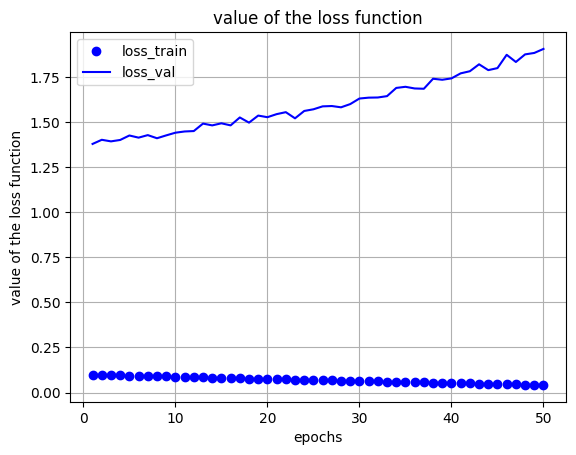

In [106]:

loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

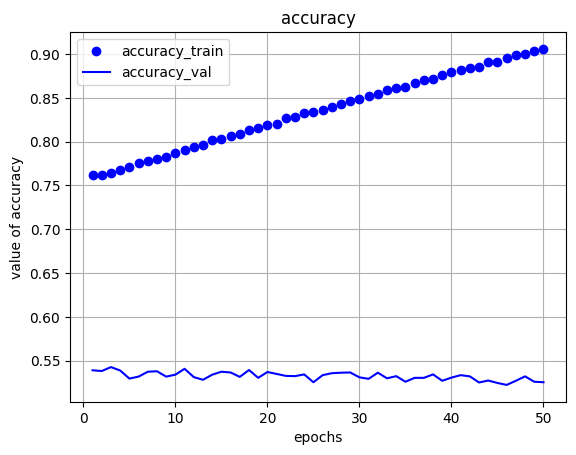

In [107]:

acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [108]:
@views.route('/CaptureImage', methods = ["POST"] )
def CaptureImage():
    xyz = request.values
    #print(xyz)
    print("yaya")
    image_b64 = request.values['img']
    image_data = re.sub('^data:image/.+;base64,', '', image_b64)
    print("####################################@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    # = Image.open(cStringIO.StringIO(image_b64))
    #image_np = np.array(image_PIL)
    imgdata = base64.b64decode(image_data)
    filename = 'website\static\Image\some_image.jpg'
    with open(filename, 'wb') as f:
        f.write(imgdata)
    #print(imgdata)
    #'Image received: {}'.format(image_np.shape)
    img = cv2.imread("website\static\Image\some_image.jpg")

    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('website\model\haarcascade_frontalface_alt2.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    print(len(faces))
    global noface
    noface = len(faces)
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), 0, 0)
            faces = img[y:y + h, x:x + w]
            gray_face = cv2.cvtColor(faces, cv2.COLOR_BGR2GRAY)
            #cv2.imshow("face", gray_face)
            #FinalYearProject/website/static/Image
            cv2.imwrite('website\static\Image\Facenew.jpg', gray_face)
            break

        # Display the output
        cv2.imwrite('detctednew.jpg', img)
        #cv2.imshow('img', img)
        #cv2.waitKey()

    #Detected_mood(classi)
    return render_template("CaptureImage.html")


@views.route('/Detected_mood')
def Detected_mood():
    model_path = "website\model\cnnbestmodel2.h5"
    # model = model_from_json(open("models/fer.json", "r").read())
    model = load_model(model_path)
    image_path = 'website\static\Image\Facenew.jpg'
    img = cv2.imread(image_path)
    img = cv2.resize(img, (48, 48))
    img = np.reshape(img, [1, 48, 48, 3])
    img1 = cv2.imread("website\static\Image\some_image.jpg")
    print(img1.shape)
    detector = FER(mtcnn=True)
    print("#########################################")
    print(detector.detect_emotions(img1))
    # image = np.array(Image.open(image_path).resize((48,48)))
    # images_list = []
    # images_list.append(np.array(image))
    # x = np.asarray(images_list)
    print(img.shape)
    yhat = model.predict(img)
    print(yhat)
    classes_x = np.argmax(yhat[0])
    print(classes_x)
    emotions = ["angry", "fear", "happy", "neutral", "sad", "surprise"]

    classi = str(emotions[classes_x])
    print(classi)
    urlpath = "http://127.0.0.1:5000/" + classi
    if noface >0:
        return render_template("Detected_mood.html", prediction=classi, urlpath=urlpath)
    else:
        urlpath = "http://127.0.0.1:5000/CaptureImage"
        return render_template("Detected_mood.html", noface="noface", urlpath=urlpath)

NameError: ignored